In [82]:
#### Matches LC-ICPMS data and LC-ESIMS data and assignes MF to peak.

#### Christian Dewey
#### 24 January 2023

import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns
import corems.lc_icpms_ftms.factory.Aligned_ICP_ESI as icpesi
import corems.lc_icpms_ftms.factory.align_icpms_esi_fns as alignfns

import importlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [5]:
# get files & parsers

dir='/Volumes/Samsung_T5/NHMFL/2023_January_Christian/wastewater/Zorbax_5um_inject_1500ms/neg/subset'
flist=os.listdir(dir)
os.chdir(dir)

# get parsers

MSfiles={}

for f in flist:
    if ('.raw' in f) & ('._' not in f) & ('qh2o' not in f):
        print(f)
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}

data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

data._raw_filelist = data.master_data_holder.keys()

20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw


In [22]:
# determine offset

icpms_b12 = 9.95  # min
esims_b12 = 9.63  # min 

offset = esims_b12 - icpms_b12 

offset

-0.3199999999999985

In [11]:
# load icpms data 

icpms_dir = '/Volumes/Samsung_T5/Keck iCAP/2023/January'

flist=os.listdir(icpms_dir)
os.chdir(icpms_dir)

# get parsers

icpms_files={}

for f in flist:
    if ('.csv' in f) :

        fnum = f.split('.')[0].split('_')[-1]
        temp = pd.read_csv(f, sep=';',header=1)
        icpms_files[fnum]={'file':f, 'data':temp}

for n in icpms_files:
    print(n, icpms_files[n]['file'])


7 cwd_230121_zorbax5um_springPPL_50uL_7.csv
8 cwd_230121_zorbax5um_springENV_50uL_8.csv
5 cwd_230121_zorbax5um_sloughPPL_50uL_5.csv
6 cwd_230121_zorbax5um_sloughENV_50uL_6.csv
3 cwd_230121_zorbax5um_qh2o_50uL_3.csv
2 cwd_230121_zorbax5um_qh2o_50uL_2.csv
1 cwd_230121_zorbax5um_qh2o_50uL_1.csv
9 cwd_230121_zorbax5um_novWasteWater_2Fdilute_BAD_50uL_9.csv
13 cwd_230121_zorbax5um_novWasteWater_2Fdilute_50uL_13.csv
11 cwd_230121_zorbax5um_janWasteWater_NoDilute_50uL_11.csv
10 cwd_230121_zorbax5um_janWasteWater_2Fdilute_BAD_50uL_10.csv
12 cwd_230121_zorbax5um_janWasteWater_2Fdilute_50uL_12.csv
14 cwd_230121_zorbax5um_1uMstdmix_50uL_14.csv
4 cwd_230121_zorbax5um_1uMstdmix_50uL_4.csv


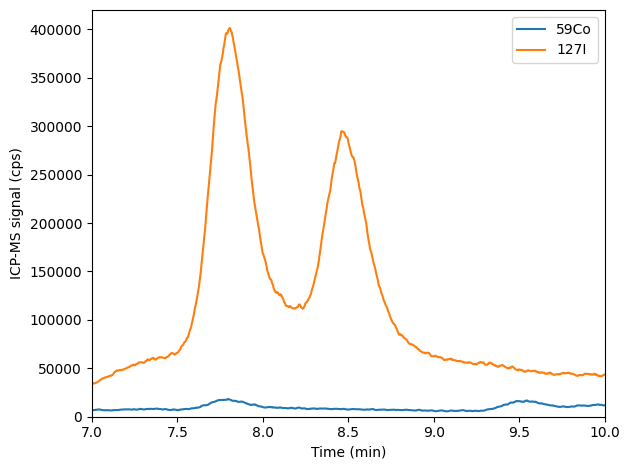

In [74]:
data = icpms_files['13']['data']

title = 'November Wastewater Sample'

labels = ['Nov. WW']
alphas = [1,0.5]
labs = {f:l for f,l in zip(flist,labels)}
transp = {f:a for f,a in zip(flist,alphas)}

elements = ['59Co', '127I']
colors = ['C0', 'C1']
cols = {m:c for m,c in zip(elements,colors)}


fig, ax = plt.subplots()

for me in elements:

    maxicp = 0 

    icpms = data
    mw = me[:2]
    sym = me[2:]
    plab = '$^{%s}$%s' %(mw,sym)
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me],color = cols[me], label =me)        
    

#ax.set_ylim(0,maxicp*1.1)
#ax.set_title(title)
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
#ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.legend(bbox_to_anchor=(1.0,1.0),loc='upper right')

ax.set_xlim(7,10)
ax.set_ylim(bottom = 0, top = 4.2e5)
#ax.yaxis.set_major_locator(MultipleLocator(1e5))

current_yvalues = plt.gca().get_yticks()
ylabs = []

#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
#plt.gca().set_yticklabels(ylabs)


fig.tight_layout()
plt.show()

In [36]:
# get peak time

icpms_peak = 7.8
esi_peak = icpms_peak + offset
esi_peak

7.480000000000001

In [37]:
parser = MSfiles['20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw']['parser']

In [95]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['I'] = (0,1)
MSParameters.molecular_search.usedAtoms['F'] = (0,6)


In [76]:
import importlib
# reload modules & set fname
importlib.reload(icpesi)


esif = dir + '/20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw'
icpf = icpms_dir + '/cwd_230121_zorbax5um_novWasteWater_2Fdilute_50uL_13.csv'

test = icpesi.Aligned_ICP_ESI(icpf,esif,'127I')

test.getMSData()

zz = test.icp_data



In [ ]:
importlib.reload(icpesi)
subicp = test.subset_icpdata()
test.timestart = 7.25
test.timestop = 9.25
test.offset= offset  # added to icpms data


results = test.assignFormulas(threshold=0.5)



In [79]:
dir='/Volumes/Samsung_T5/NHMFL/2023_January_Christian/wastewater/Zorbax_5um_inject_1500ms/neg/subset'
flist=os.listdir(dir)
os.chdir(dir)

# get parsers

MSfiles={}

for f in flist:
    if ('.raw' in f) & ('._' not in f) & ('qh2o' not in f):
        print(f)
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}

data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

data._raw_filelist = data.master_data_holder.keys()

20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw


In [81]:
timerange = [7,8]  # start (min) to stop (min)
interval = 1  # min 
refmasslist = "/Users/christiandewey/CoreMS/db/Hawkes_neg.ref"

data.assign_formula(interval = interval, timerange = timerange, 
    refmasslist = refmasslist, calorder =2, charge = 1, cal_ppm_threshold= (0,3))
#data_df = lcmsfns.assign_formula(parser=parser, interval = interval, timerange = timerange, refmasslist = refmasslist, calorder =2, charge = -1)

data_df = data.complete_results_df



20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw
1 of 4 files
timestart: 7
negative
MS Obj loaded - 501 peaks found.
MS Obj loaded - 501 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
86 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 351 fn evals and 7 iterations


100%|██████████| 2560/2560 [00:02<00:00, 1025.86it/s]


Started database insert using 63191 iterations for a total of 3159513 rows


63191it [05:21, 196.55it/s]


'runworker'  325010.10 ms


Loading molecular formula database: 242060it [00:07, 33416.38it/s] 
Started molecular formula search for class {"O": 10, "I": 1, "F": 1, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 214.40it/s]       
Loading molecular formula database: 241893it [00:07, 32757.66it/s] 
Started molecular formula search for class {"S": 1, "O": 19, "F": 3, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 628.25it/s]        
Loading molecular formula database: 244078it [00:06, 36365.65it/s] 
Started molecular formula search for class {"N": 1, "O": 9, "F": 1, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 368.44it/s]                
Loading molecular formula database: 244714it [00:07, 33007.72it/s] 
Started molecular formula search for class {"N": 1, "O": 18, "I": 1, "F": 3, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 710.71it/s]        
Loading molecular formula database: 245977it [00:07, 35133.53it/s] 
Started molecular formula 

'run_molecular_formula'  391477.50 ms
468 assigned peaks and 33 unassigned peaks, total  = 93.41 %, relative abundance = 68.00 %, RMS error (best candidate) (ppm) = 0.052


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw
2 of 4 files
timestart: 7
negative
MS Obj loaded - 561 peaks found.
MS Obj loaded - 561 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
114 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 355 fn evals and 7 iterations
'runworker'  46.78 ms


Loading molecular formula database: 242060it [00:07, 32599.56it/s] 
Started molecular formula search for class {"O": 10, "I": 1, "F": 1, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 197.41it/s]       
Loading molecular formula database: 241893it [00:07, 31972.45it/s] 
Started molecular formula search for class {"S": 1, "O": 19, "F": 3, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 485.52it/s]        
Loading molecular formula database: 244078it [00:06, 35370.02it/s] 
Started molecular formula search for class {"N": 1, "O": 9, "F": 1, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 260.42it/s]                
Loading molecular formula database: 244714it [00:07, 34432.79it/s] 
Started molecular formula search for class {"N": 1, "O": 18, "I": 1, "F": 3, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 622.28it/s]        
Loading molecular formula database: 245977it [00:07, 31199.83it/s]
Started molecular formula s

'run_molecular_formula'  69734.16 ms
528 assigned peaks and 33 unassigned peaks, total  = 94.12 %, relative abundance = 70.52 %, RMS error (best candidate) (ppm) = 0.056


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw
3 of 4 files
timestart: 7
negative
MS Obj loaded - 468 peaks found.
MS Obj loaded - 468 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
74 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 361 fn evals and 7 iterations
'runworker'  130.64 ms


Loading molecular formula database: 242060it [00:07, 30749.74it/s]
Started molecular formula search for class {"O": 10, "I": 1, "F": 1, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 306.62it/s]       
Loading molecular formula database: 241893it [00:08, 29314.90it/s] 
Started molecular formula search for class {"S": 1, "O": 19, "F": 3, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 421.08it/s]        
Loading molecular formula database: 244078it [00:08, 28083.63it/s] 
Started molecular formula search for class {"N": 1, "O": 9, "F": 1, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 406.68it/s]                
Loading molecular formula database: 244714it [00:08, 30286.87it/s] 
Started molecular formula search for class {"N": 1, "O": 18, "I": 1, "F": 3, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 463.48it/s]        
Loading molecular formula database: 245977it [00:08, 29193.02it/s]
Started molecular formula se

'run_molecular_formula'  77115.07 ms
419 assigned peaks and 49 unassigned peaks, total  = 89.53 %, relative abundance = 87.46 %, RMS error (best candidate) (ppm) = 0.069


20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw
4 of 4 files
timestart: 7
negative
MS Obj loaded - 625 peaks found.
MS Obj loaded - 625 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
113 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.284 ppm
minimize function performed 307 fn evals and 6 iterations
'runworker'  44.55 ms


Loading molecular formula database: 242060it [00:09, 26297.24it/s]
Started molecular formula search for class {"O": 10, "I": 1, "F": 1, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 205.42it/s]       
Loading molecular formula database: 241893it [00:09, 26421.62it/s]
Started molecular formula search for class {"S": 1, "O": 19, "F": 3, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 267.77it/s]        
Loading molecular formula database: 244078it [00:09, 25252.36it/s]
Started molecular formula search for class {"N": 1, "O": 9, "F": 1, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 256.93it/s]                
Loading molecular formula database: 244714it [00:09, 26990.68it/s]
Started molecular formula search for class {"N": 1, "O": 18, "I": 1, "F": 3, "Cl": 1}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 345.55it/s]        
Loading molecular formula database: 245977it [00:10, 24487.43it/s]
Started molecular formula searc

'run_molecular_formula'  92249.33 ms
560 assigned peaks and 65 unassigned peaks, total  = 89.60 %, relative abundance = 78.42 %, RMS error (best candidate) (ppm) = 0.090


In [99]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['I'] = (0,1)
MSParameters.molecular_search.usedAtoms['F'] = (0,6)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.usedAtoms['Cl'] = (0,0)

In [106]:
importlib.reload(lcmsfns)
timerange = [7,8]  # start (min) to stop (min)
interval = 1  # min 
refmasslist = "/Users/christiandewey/CoreMS/db/Hawkes_neg.ref"

parser = MSfiles['20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw']['parser']

data_df = lcmsfns.assign_formula(parser, interval = interval, timerange = timerange, 
    refmasslist = refmasslist, corder =2, charge = 1, cal_ppm_threshold= (0,3))

timestart: 7
negative
MS Obj loaded - 732 peaks found.
MS Obj loaded - 732 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
130 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.046 ppm
minimize function performed 318 fn evals and 6 iterations
'runworker'  57.80 ms


Loading molecular formula database: 238966it [00:08, 29803.38it/s] 
Started molecular formula search for class {"N": 1, "O": 2, "F": 5}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 289.18it/s]        
Loading molecular formula database: 241838it [00:07, 33179.09it/s] 
Started molecular formula search for class {"N": 2, "O": 3, "I": 1, "F": 4}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 333.21it/s] 
Loading molecular formula database: 244341it [00:08, 30177.51it/s]
Started molecular formula search for class {"N": 3, "O": 5, "F": 3}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 352.69it/s]         
Loading molecular formula database: 246325it [00:07, 34976.21it/s] 
Started molecular formula search for class {"N": 4, "O": 6, "I": 1, "F": 2}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 337.30it/s] 
Loading molecular formula database: 164411it [00:05, 30989.69it/s]
Started molecular formula search for class {"N": 4, "O": 20, "I": 1, "F": 6}, (

'run_molecular_formula'  39979.99 ms
610 assigned peaks and 122 unassigned peaks, total  = 83.33 %, relative abundance = 87.84 %, RMS error (best candidate) (ppm) = 0.087


In [107]:
icpf = icpms_dir + '/cwd_230121_zorbax5um_novWasteWater_2Fdilute_50uL_13.csv'
icpdata = pd.read_csv(icpf,sep=';',header=1 )

subicp = alignfns.subset_icpdata(icp_data = icpdata, timerange=timerange)

eics, avms = alignfns.get_eics(esi_parser=parser, timerange = timerange)

negative


Getting EICs: 100%|██████████| 732/732 [04:38<00:00,  2.62it/s]


In [108]:
importlib.reload(alignfns)
icpinterp = alignfns.interp(esi_parser =parser,timerange=timerange,icpsub=subicp)

Interpolating ICPMS data: 100%|██████████| 35/35 [00:00<00:00, 2839.25it/s]


In [110]:
importlib.reload(alignfns)
assignments = data_df#[data_df['file'] == '20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw']
allresults, bestresults = alignfns.correlate(icp_interp=icpinterp,assignments=assignments, EICdic=eics, timerange=[7,8])

Running correlation: 100%|██████████| 732/732 [00:00<00:00, 1069.07it/s]


KeyError: 'I'

In [ ]:


mzc, averagems = test.subset_esidata()

test.subset_icpdata()
forms = test.assignFormulas(elementDict)

ms1 = ms1[0]

fig, ax = plt.subplots()
x = eic1.time
y = eic1.eic
ax.plot(x,y)
plt.show()